# Data-processing notebook

In [17]:
import os
import re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

#### Set your variables below

In [2]:
build_folder = "cmake-build-debug/source"
project_folders = [
    "nbodies-cpu",
    "nbodies-cuda",
    "nbodies-opencl"
]
folder_prefix = "data"

names = ['iterations', 'particles-per-second']

In [3]:
"""
projects =
{
    #project
    'nbodies-cuda': {
    
        #experiment
        'data-global-1d': {
            
            #dataset_name
            'iterations': {
                'plot':figure,
                'dataframe':df
            },
            
            'particles_per_second': {...}
        , ...}
    }, ...
}
"""

projects = {}

In [33]:
def extract_numbers(string):
    pattern = r'\((\d+),(\d+)\)'  # Regular expression pattern
    matches = re.findall(pattern, string)  # Find all matches

    # Extract numbers from matches
    numbers = [(int(match[0]), int(match[1])) for match in matches]

    return numbers[0]

def compute_fig_title(path, title):
    fig_title = ""
    if 'cuda' in path:
        fig_title += "CUDA"
    elif 'opencl' in path:
        fig_title += "OpenCL"
    else:
        fig_title += "CPU"
    
    fig_title += f" {title} ("
    
    if 'local' in path:
        fig_title += "memory=local, "
    elif 'global' in path:
        fig_title += "memory=global, "
    
    block_size, num_bodies = extract_numbers(path)
    
    if '1d' in path:
        fig_title += f"dim=1D, blockSize={block_size}, "
    elif '2d' in path:
        fig_title += f"dim=2D, blockSize={block_size}, "
    
    
    fig_title += f"n={num_bodies})"
    
    
    return fig_title

def fill_dataset(path, title):
    print("reading", path, title)
    df = pd.read_csv(path, header=None)
    fig, ax = plt.subplots()
    fig_title = compute_fig_title(path, title)
    
    if title == 'iterations':
        ax.plot(df[0], df[1])
        ax.set_xlabel('time (s)')
        ax.set_ylabel('iterations')
        ax.set_xlim(left=0)
        ax.set_ylim(bottom=0)
    elif title == 'particles-per-second':
        ax.plot(df[0], df[1])
        ax.set_xlabel('time (s)')
        ax.set_ylabel('particles/second')
        ax.set_xlim(left=0)
        ax.set_ylim(bottom=min(df[1])*0.95)  # log scale can't handle 0, obviously
        #ax.set_yscale('log')
    
    ax.set_title(fig_title)
    
    if not os.path.exists('plots'):
        os.makedirs('plots')
    fig.savefig(os.path.join('plots', fig_title+'.jpg'))
    
    return {'df': df, 'fig': fig, 'ax': ax}

def fill_experiment(project, folder, path: str):
    files = [os.path.join(data_path, name + '.csv') for name in names]
    experiment = {}
    for file in files:
        if not os.path.exists(file):
            print("file:", file, "does not exist.")
            continue
        dataset_name = os.path.splitext(os.path.basename(file))[0]
        experiment[dataset_name] = fill_dataset(file, dataset_name)
    return experiment

#### Encontrar los archivos y llamar a la función

reading cmake-build-debug/source\nbodies-cpu\data--(0,4096)\iterations.csv iterations
reading cmake-build-debug/source\nbodies-cpu\data--(0,4096)\particles-per-second.csv particles-per-second
reading cmake-build-debug/source\nbodies-cuda\data-global-1d-(256,16127)\iterations.csv iterations
reading cmake-build-debug/source\nbodies-cuda\data-global-1d-(256,16127)\particles-per-second.csv particles-per-second
reading cmake-build-debug/source\nbodies-cuda\data-global-2d-(256,16127)\iterations.csv iterations
reading cmake-build-debug/source\nbodies-cuda\data-global-2d-(256,16127)\particles-per-second.csv particles-per-second
reading cmake-build-debug/source\nbodies-cuda\data-local-1d-(256,16127)\iterations.csv iterations
reading cmake-build-debug/source\nbodies-cuda\data-local-1d-(256,16127)\particles-per-second.csv particles-per-second
reading cmake-build-debug/source\nbodies-cuda\data-local-2d-(256,16127)\iterations.csv iterations
reading cmake-build-debug/source\nbodies-cuda\data-local-2

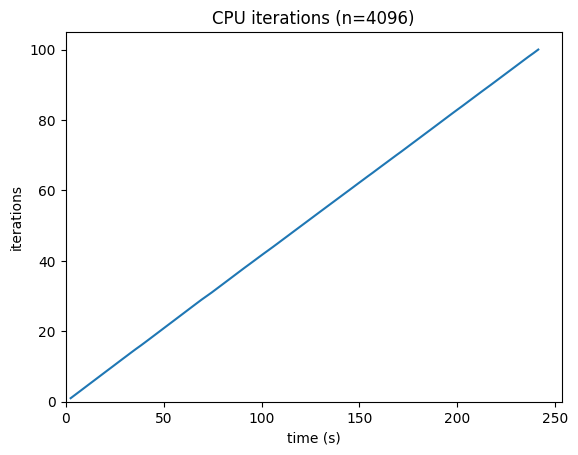

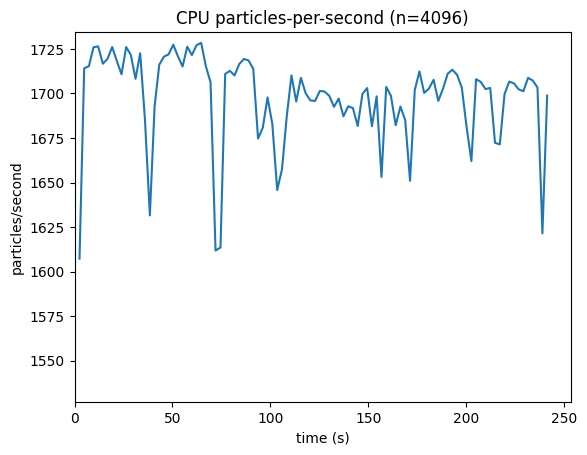

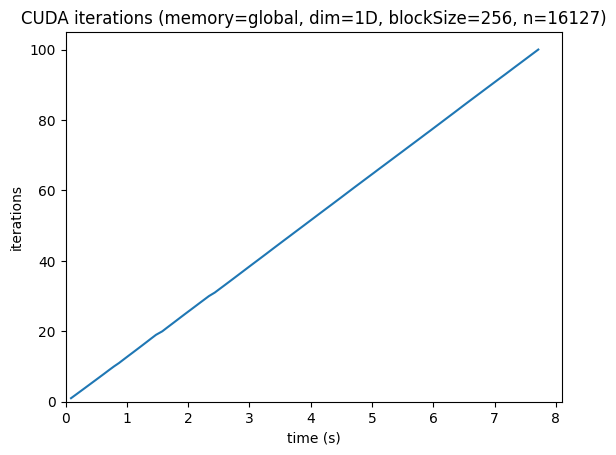

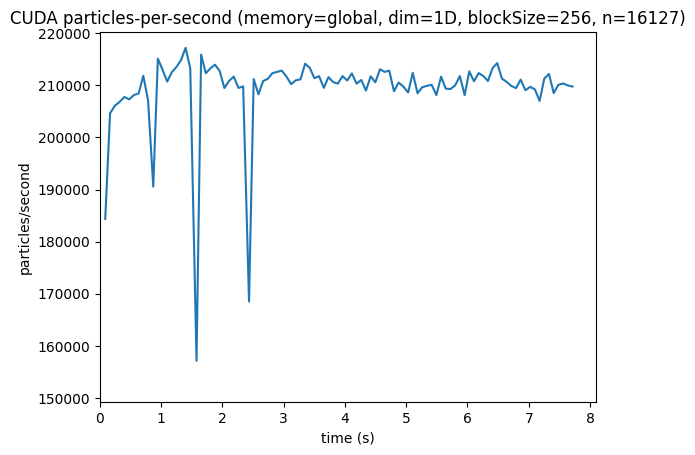

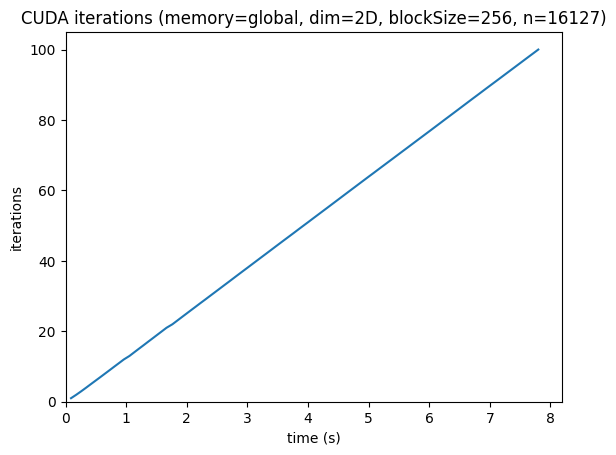

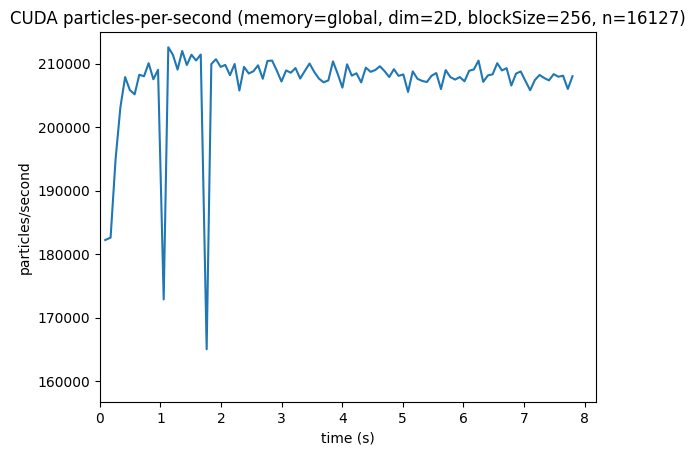

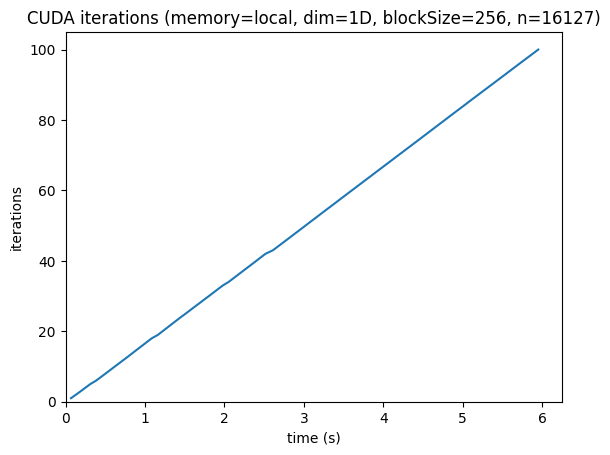

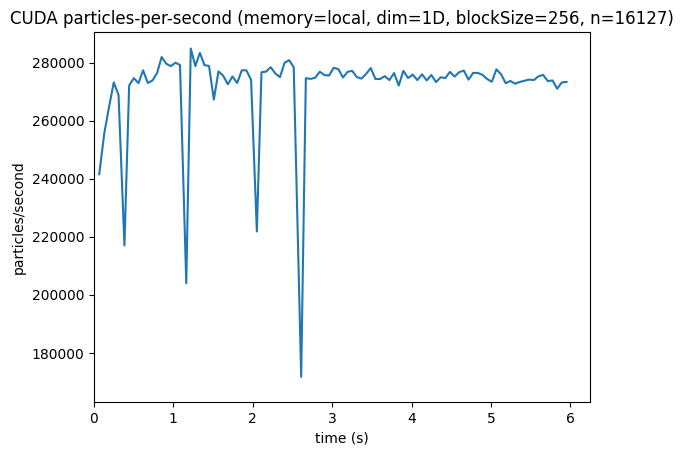

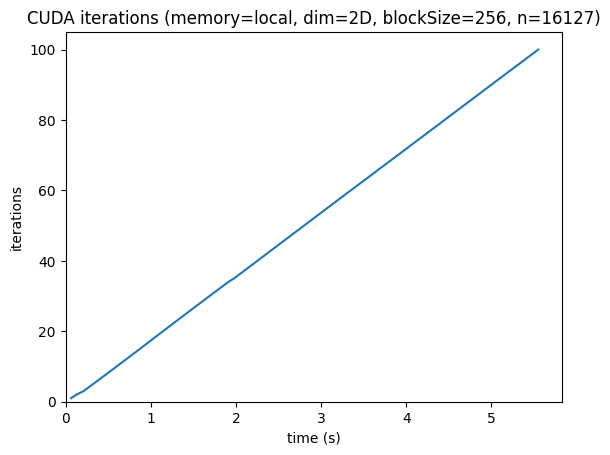

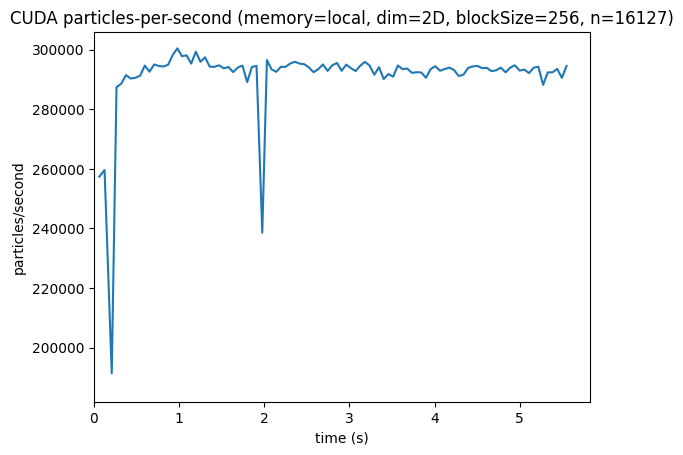

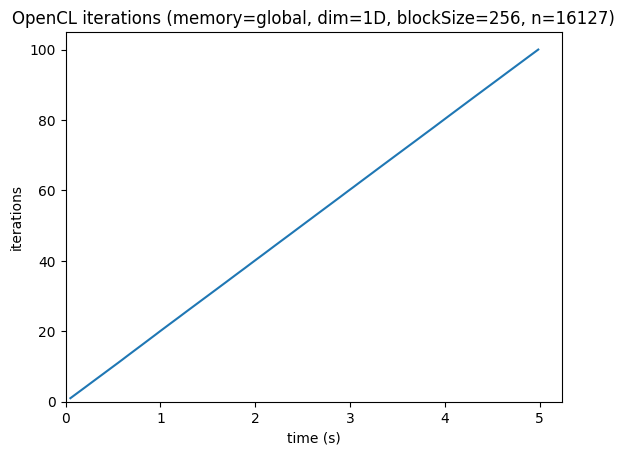

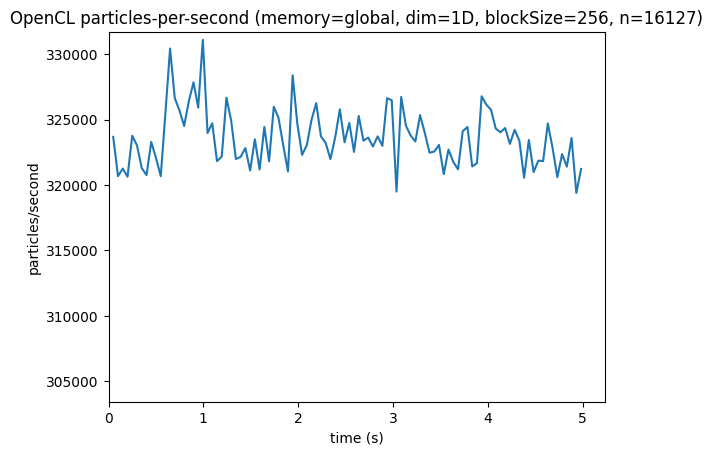

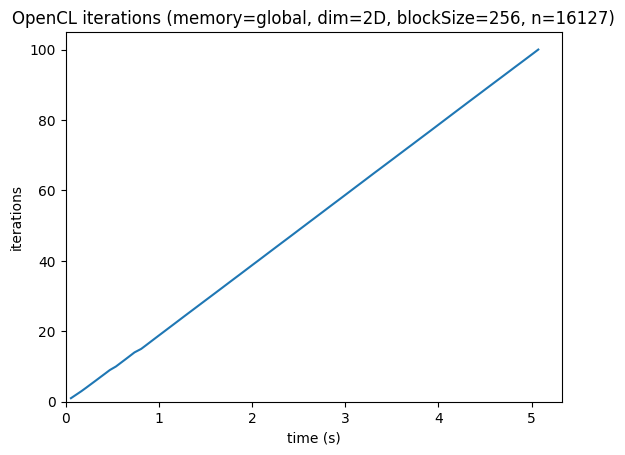

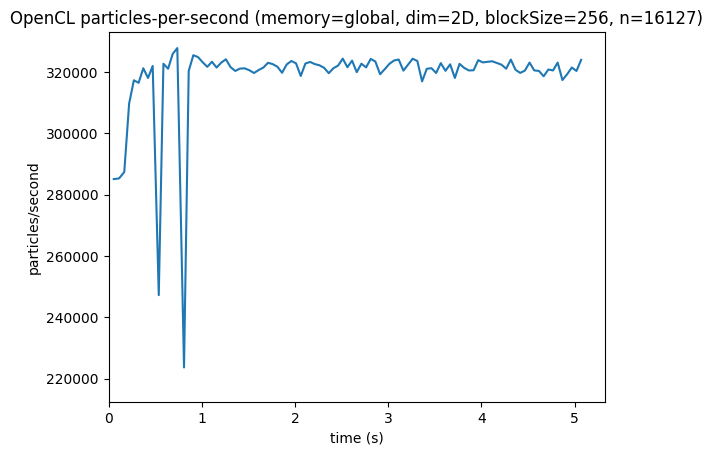

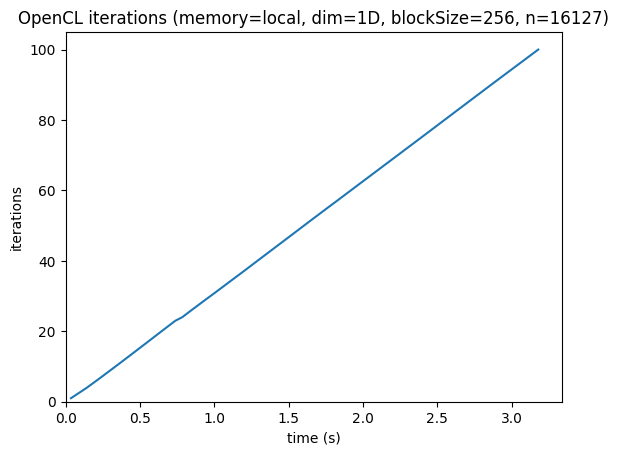

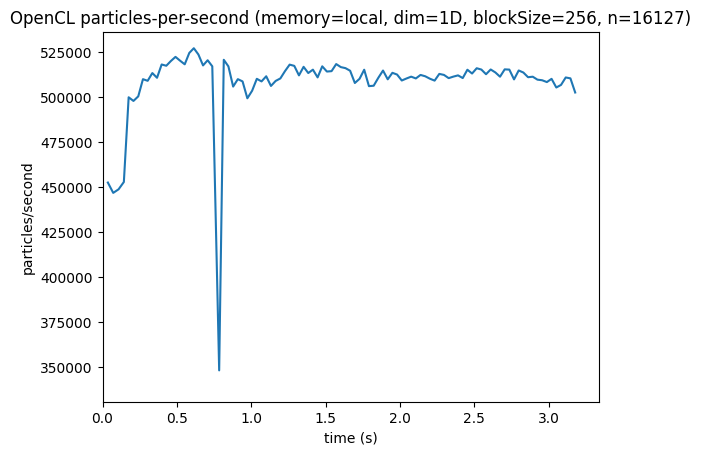

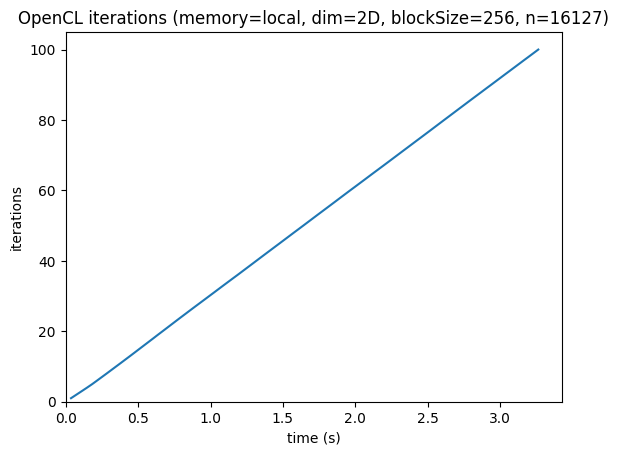

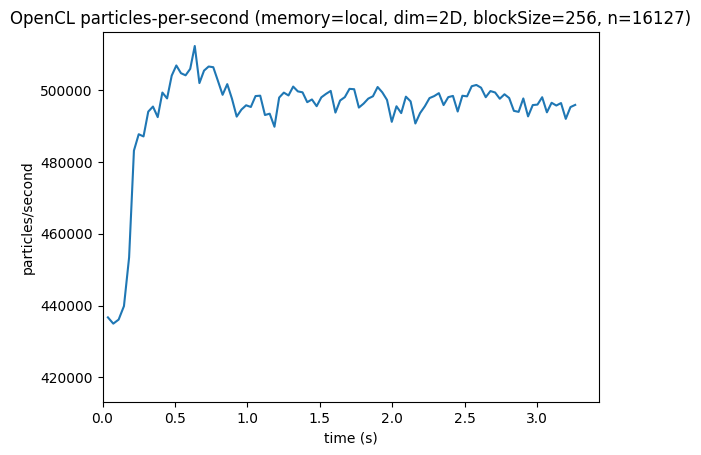

In [34]:
for p_folder in project_folders:
    projects[p_folder] = {}
    
    project_path = os.path.join(build_folder, p_folder)
    for experiment_folder in os.listdir(project_path):
        data_path = os.path.join(project_path, experiment_folder)
        if os.path.isdir(data_path) and experiment_folder.startswith(folder_prefix):
            projects[p_folder][experiment_folder] = fill_experiment(p_folder, experiment_folder, data_path)

### Mixing figures

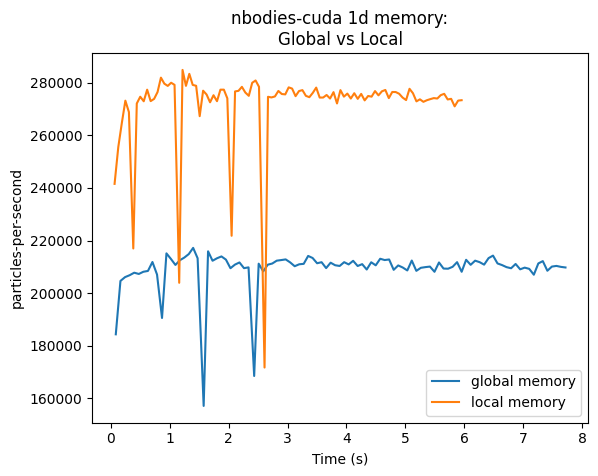

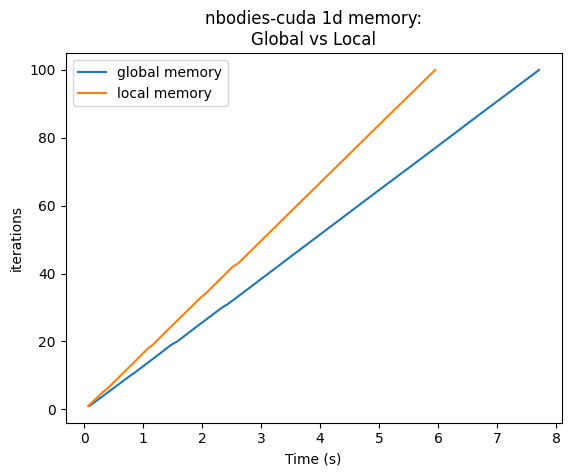

In [7]:
def plot_global_local_comparision(project, dataset_name):
    fig, ax = plt.subplots()
    df_global = projects[project]['data-global-1d-(256,16127)'][dataset_name]['df']
    df_local = projects[project]['data-local-1d-(256,16127)'][dataset_name]['df']
    ax.plot(df_global[0], df_global[1], label='global memory')
    ax.plot(df_local[0], df_local[1], label='local memory')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel(dataset_name)
    ax.set_title(project + ' 1d memory:\nGlobal vs Local')
    ax.legend()
    
plot_global_local_comparision('nbodies-cuda', 'particles-per-second')
plot_global_local_comparision('nbodies-cuda', 'iterations')